## Part 1: Toronto postcodes data scraping

##### After spending an embarassing amount of time on configuring libraries for scraping web pages, turns out all you need is pandas (should have read all the submission instructions first..)


In [1]:
import pandas as pd

#### Read wikipedia table and assign to dataframe

In [2]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
Neighborhoods_df = pd.DataFrame(data[0])
Neighborhoods_df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


#### Clean up dataframe, only keep assigned postcodes

In [3]:
Neighborhoods_df.dropna(subset=['Neighborhood'],inplace=True)
Neighborhoods_df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


#### Lastly, list neighborhoods under the same post code using commas

In [4]:
Neighborhoods_df['Neighborhood'] = Neighborhoods_df['Neighborhood'].str.replace('/',',')
Neighborhoods_df = Neighborhoods_df.reset_index(drop = True)
Neighborhoods_df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [5]:
Neighborhoods_df.shape

(103, 3)

## Part 2: Update dataframe with neighborhood coordinates

#### Ended up having to load location data from csv

In [6]:
location_data = pd.read_csv('http://cocl.us/Geospatial_data')
location_df = pd.DataFrame(location_data)
location_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Sorting Neighboorhoods in the same order

In [7]:
Neighborhoods_df.sort_values(by=['Postal code'], inplace = True, )
Neighborhoods_df = Neighborhoods_df.reset_index(drop = True)
Neighborhoods_df.head()

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Now we want to add the location info to Neighborhoods

In [8]:
location_df.drop(columns=['Postal Code'], inplace = True)
Neighborhoods_df = pd.concat([Neighborhoods_df, location_df], axis=1) 
Neighborhoods_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3: Explore and cluster Toronto neighborhoods

In [9]:
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

# All requested packages already installed.



#### Borrowed the skills lab function to extract venue categories

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### When trying to run subsequent sections on the full dataset, it seemed that some neighborhoods have no listed venues. Let's restrict to Downtown Toronto

In [11]:
Toronto_df = Neighborhoods_df[Neighborhoods_df.Borough =='Downtown Toronto']
Toronto_df = Toronto_df.reset_index(drop = True)
Toronto_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"St. James Town , Cabbagetown",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
4,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


#### Turn to Foursquare to find the venues in each neighborhood

In [12]:
CLIENT_ID = '52N0QP5ME4N5VLLIJPGPB4JXVNW3J2FEOTLMPWL5Y3LFYD2J' 
CLIENT_SECRET = 'KGA0SNI0DESCREVQ0SIKAGR32E4KXXMZWM3LPEVRUMEP5QXA' 
VERSION = '20180605'

LIMIT = 100
RADIUS = 500


#### Create new dataframe and populate it with venues in each neighborhood

In [14]:
# Create new data frame for venues

Toronto_venues = pd.DataFrame(columns=['Neighborhood','Neighborhood Latitude','Neighborhood Longitude',
                          'Venue','Venue Latitude','Venue Longitude','Venue category'])

#Now loop over the neighborhoods and extract venue info for each of them

for i in range(len(Toronto_df)):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        Toronto_df['Latitude'][i],
        Toronto_df['Longitude'][i],
        RADIUS, 
        LIMIT)

    results = requests.get(url).json()
    
    # get the venue info
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    
    for ii in range(len(nearby_venues)):
        Toronto_venues = Toronto_venues.append({'Neighborhood':Toronto_df['Neighborhood'][i],
                             'Neighborhood Latitude':Toronto_df['Latitude'][i],
                             'Neighborhood Longitude':Toronto_df['Longitude'][i],
                             'Venue':nearby_venues['name'][ii],
                             'Venue Latitude':nearby_venues['lat'][ii],
                             'Venue Longitude':nearby_venues['lng'][ii],
                             'Venue category':nearby_venues['categories'][ii]}, ignore_index = True)
    
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"St. James Town , Cabbagetown",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


#### Rearrange the dataframe creating columns for each venue category

In [15]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Average the number of venues in each category per neighborhood

In [16]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.017857,0.000000,0.000000,0.0,0.0,0.017857,0.0,0.0,0.000000,0.0
1,"CN Tower , King and Spadina , Railway Lands , ...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,Central Bay Street,0.015625,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.015625,...,0.015625,0.000000,0.000000,0.0,0.0,0.015625,0.0,0.0,0.015625,0.0
3,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,Church and Wellesley,0.026667,0.013333,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.013333,...,0.013333,0.013333,0.013333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


#### Find optimal number of clusters and cluster neighborhoods

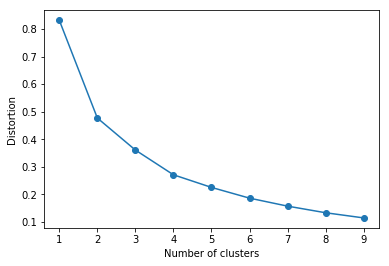

In [18]:
import matplotlib.pyplot as plt

Toronto_clustering = Toronto_grouped.drop('Neighborhood', 1)
wcss = []

# find the elbow point based on within-cluster sum of squares (wcss)
for kclusters in range(1, 10):

    kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(Toronto_clustering)
    wcss.append(kmeans.inertia_)
    
  
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.show()

In [19]:
# Not an obvious elbow point IMO.. Will go on with 5 clusters for the purpose of the exercise

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(Toronto_clustering)

##### To visualise the clusters we actually only need neighborhood name, location coordinates and cluster label

In [20]:
# add clustering labels
Toronto_df.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_df.head() 

,Cluster Labels,Postal code,Borough,Neighborhood,Latitude,Longitude
0,0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,3,M4X,Downtown Toronto,"St. James Town , Cabbagetown",43.667967,-79.367675
2,4,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
4,0,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


#### Create a map and visualise the clusters

In [21]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
import numpy as np

address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighborhood'], Toronto_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters